B5W1: Predicting Price Moves with News Sentiment

Step 0: Import Libraries and Load Dataset

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging
from sklearn.feature_extraction.text import CountVectorizer
import textstat
import numpy as np
sns.set(style='whitegrid')
%matplotlib inline



In [24]:
class Config:
    DATA_PATH = "../data/raw_analyst_ratings.csv"
    STOCK_FILES = {
        "AAPL": "../data/yfinance_data/AAPL_historical_data.csv",
        "AMZN": "../data/yfinance_data/AMZN_historical_data.csv",
        "GOOG": "../data/yfinance_data/GOOG_historical_data.csv",
        "META": "../data/yfinance_data/META_historical_data.csv",
        "MSFT": "../data/yfinance_data/MSFT_historical_data.csv",
        "NVDA": "../data/yfinance_data/NVDA_historical_data.csv",
        "TSLA": "../data/yfinance_data/TSLA_historical_data.csv"
    }

In [3]:
# Step 2: Define a DataLoader Class
class DataLoader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = self._load_data()

    def _load_data(self):
        if not os.path.exists(self.filepath):
            raise FileNotFoundError(f"File not found: {self.filepath}")
        return pd.read_csv(self.filepath)

    def summary_statistics(self):
        print("Summary Statistics:")
        display(self.df.describe())
        display(self.df.head())

In [4]:
# Step 3: Use the Class on a Country Dataset
# Replace this with the actual path to your data file
data_path = Config.DATA_PATH

# Create profiler instance
loader = DataLoader(data_path)

# Show summary statistics
loader.summary_statistics()

Summary Statistics:


,Unnamed: 0
count,1.407328e+06
mean,7.072454e+05
std,4.081009e+05
min,0.000000e+00
25%,3.538128e+05
50%,7.072395e+05
75%,1.060710e+06
max,1.413848e+06


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
# Assuming DataLoader is defined and loads self.df

from collections import Counter
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from pandas.api.types import is_datetime64_any_dtype

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

class NewsHeadlineEDA(DataLoader):
    def __init__(self, filepath):
        super().__init__(filepath)
        self._clean_data()
        self._add_text_statistics()
        self._add_readability_score()

    def _validate_columns(self, required_cols):
        missing = [col for col in required_cols if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

    def _clean_data(self):
        self.df.dropna(subset=['headline'], inplace=True)
        if 'date' in self.df.columns:
            self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
            self.df.dropna(subset=['date'], inplace=True)

    def _add_text_statistics(self):
        self.df['headline_length'] = self.df['headline'].apply(len)
        self.df['word_count'] = self.df['headline'].apply(
            lambda x: len(x.split()))

    def _add_readability_score(self):
        self.df['readability'] = self.df['headline'].apply(
            lambda x: textstat.flesch_reading_ease(x))

    def show_text_length_stats(self):
        print("Descriptive statistics for text lengths:\n",
              self.df[['headline_length', 'word_count']].describe())

        # Headline length
        plt.figure(figsize=(10, 5))
        sns.histplot(self.df['headline_length'], bins=30,
                     kde=True, color='cornflowerblue')
        plt.title("Distribution of Headline Lengths")
        plt.xlabel("Character Count")
        plt.ylabel("Frequency")
        plt.show()

        # Word count
        plt.figure(figsize=(10, 5))
        sns.histplot(self.df['word_count'], bins=30,
                     kde=True, color='mediumseagreen')
        plt.title("Distribution of Word Counts")
        plt.xlabel("Word Count")
        plt.ylabel("Frequency")
        plt.show()

    def analyze_publishers(self):
        self._validate_columns(['publisher'])

        publisher_counts = self.df['publisher'].value_counts()
        print("Top 10 Publishers:\n", publisher_counts.head(10))

        plt.figure(figsize=(12, 6))
        sns.barplot(x=publisher_counts.head(10).values,
                    y=publisher_counts.head(10).index, palette='mako')
        plt.title("Top 10 Publishers by Number of Articles")
        plt.xlabel("Article Count")
        plt.ylabel("Publisher")
        plt.show()

    def analyze_publication_dates(self):
        self._validate_columns(['date'])

        self.df['year'] = self.df['date'].dt.year
        self.df['month'] = self.df['date'].dt.month
        self.df['day_of_week'] = self.df['date'].dt.day_name()

        daily_counts = self.df['date'].value_counts().sort_index()

        plt.figure(figsize=(14, 6))
        daily_counts.plot()
        plt.title("Article Frequency Over Time")
        plt.xlabel("Date")
        plt.ylabel("Number of Articles")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.countplot(data=self.df, x='day_of_week',
                      order=['Monday', 'Tuesday', 'Wednesday',
                             'Thursday', 'Friday', 'Saturday', 'Sunday'],
                      palette='viridis')
        plt.title("Articles by Day of the Week")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.show()

    def show_year_month_heatmap(self):
        self._validate_columns(['date'])

        pub_counts = self.df.groupby(
            [self.df['date'].dt.year, self.df['date'].dt.month]).size().unstack(fill_value=0)

        plt.figure(figsize=(12, 6))
        sns.heatmap(pub_counts, cmap="Blues",
                    linewidths=.5, annot=True, fmt="d")
        plt.title("Monthly Article Frequency Over Years")
        plt.xlabel("Month")
        plt.ylabel("Year")
        plt.show()

    def publisher_trend_over_time(self, top_n=5):
        self._validate_columns(['publisher', 'date'])

        top_publishers = self.df['publisher'].value_counts().head(top_n).index
        df_filtered = self.df[self.df['publisher'].isin(top_publishers)]
        df_filtered['month'] = df_filtered['date'].dt.to_period('M')
        trend = df_filtered.groupby(
            ['month', 'publisher']).size().unstack().fillna(0)

        trend.plot(figsize=(14, 6), title="Top Publisher Trends Over Time")
        plt.xlabel("Month")
        plt.ylabel("Article Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def show_top_keywords(self, n=20):
        self._validate_columns(['headline'])

        vectorizer = CountVectorizer(stop_words='english', max_features=n)
        X = vectorizer.fit_transform(self.df['headline'])
        keywords = pd.Series(X.toarray().sum(
            axis=0), index=vectorizer.get_feature_names_out())
        keywords.sort_values(ascending=True).plot(
            kind='barh', figsize=(10, 6), title='Top Headline Keywords')
        plt.xlabel("Frequency")
        plt.show()

    def publisher_headline_length_comparison(self, top_n=10):
        self._validate_columns(['publisher', 'headline_length'])

        top_publishers = self.df['publisher'].value_counts().head(top_n).index
        df_filtered = self.df[self.df['publisher'].isin(top_publishers)]

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_filtered, x='publisher',
                    y='headline_length', order=top_publishers)
        plt.xticks(rotation=45)
        plt.title("Headline Length by Publisher")
        plt.tight_layout()
        plt.show()
        
    # Text Analysis(Topic Modeling):
    def _preprocess_text(self, text):
        # Basic cleaning: lower, remove punctuation, numbers
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize and lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words('english')]

        return ' '.join(tokens)

    def run_topic_modeling(self, n_topics=5, n_top_words=10, method='nmf'):
        if 'headline' not in self.df.columns:
            print("Headline column not found.")
            return

        print("Preprocessing headlines...")
        self.df['clean_headline'] = self.df['headline'].apply(self._preprocess_text)

        print("Vectorizing text...")
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(self.df['clean_headline'])

        if method == 'nmf':
            model = NMF(n_components=n_topics, random_state=42)
        elif method == 'lda':
            model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        else:
            raise ValueError("Method must be 'nmf' or 'lda'")

        print(f"Fitting {method.upper()} model...")
        model.fit(tfidf)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        print("\nTopics discovered:")
        for topic_idx, topic in enumerate(model.components_):
            top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            print(f"Topic {topic_idx + 1}: {' | '.join(top_features)}")


    # Time Series Analysis:

    def analyze_publication_trends(self, window=7):
        if 'date' not in self.df.columns:
            print("No 'date' column available for time series analysis.")
            return

        print("Analyzing article frequency over time...")

        # Daily count of headlines
        daily_counts = self.df.groupby(self.df['date'].dt.date).size()
        rolling_avg = daily_counts.rolling(window=window).mean()

        # Threshold for spike detection (1.5 * std above moving average)
        spike_threshold = rolling_avg + 1.5 * daily_counts.std()

        plt.figure(figsize=(14, 6))
        plt.plot(daily_counts.index, daily_counts.values,
                label='Daily Count', alpha=0.6)
        plt.plot(rolling_avg.index, rolling_avg.values,
                label=f'{window}-Day Moving Average', linewidth=2)
        plt.plot(spike_threshold.index, spike_threshold.values,
                label='Spike Threshold', linestyle='--', color='red')

        # Highlight spikes
        spike_dates = daily_counts[daily_counts > spike_threshold].index
        for spike in spike_dates:
            plt.axvline(spike, color='red', alpha=0.3, linestyle='--')

        plt.title("News Publication Frequency Over Time")
        plt.xlabel("Date")
        plt.ylabel("Number of Articles")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Detected {len(spike_dates)} spike(s) in publication frequency.")
        if len(spike_dates) > 0:
            print("Spikes occurred on:")
            for date in spike_dates:
                print(f" - {date}: {daily_counts[date]} articles")

    def analyze_publication_times(self):
        if 'date' not in self.df.columns:
            print("No 'date' column with time available.")
            return

        if not is_datetime64_any_dtype(self.df['date']):
            print("Column 'date' must be datetime type with time info.")
            return

        # Convert timezone-aware datetime to naive (optional, for consistency)
        if self.df['date'].dt.tz is not None:
            self.df['date'] = self.df['date'].dt.tz_convert(None)

        print("Analyzing article publishing times (hour of day)...")
        self.df['hour'] = self.df['date'].dt.hour

        plt.figure(figsize=(10, 5))
        sns.countplot(x='hour', data=self.df, palette='coolwarm')
        plt.title("Distribution of News Publishing Times")
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Articles")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    # Publisher Analysis:

    def analyze_publishers_extended(self):
        if 'publisher' not in self.df.columns:
            print("No 'publisher' column found.")
            return

        # Clean empty and null values
        self.df['publisher'] = self.df['publisher'].fillna(
            '').astype(str).str.strip()
        self.df = self.df[self.df['publisher'] != '']

        # --- 1. Count articles per publisher ---
        publisher_counts = self.df['publisher'].value_counts()
        print("Top 10 Publishers by Article Count:\n", publisher_counts.head(10))

        plt.figure(figsize=(12, 6))
        sns.barplot(y=publisher_counts.head(10).index,
                    x=publisher_counts.head(10).values, palette='crest')
        plt.title("Top 10 Publishers")
        plt.xlabel("Number of Articles")
        plt.ylabel("Publisher")
        plt.tight_layout()
        plt.show()

        # --- 2. If publishers are emails, analyze domain frequencies ---
        email_publishers = self.df[self.df['publisher'].str.contains('@')]
        if not email_publishers.empty:
            domains = email_publishers['publisher'].apply(
                lambda x: x.split('@')[-1])
            domain_counts = domains.value_counts()

            print("\nTop 10 Publisher Email Domains:\n", domain_counts.head(10))

            plt.figure(figsize=(10, 5))
            sns.barplot(x=domain_counts.head(10).values,
                        y=domain_counts.head(10).index, palette='flare')
            plt.title("Top 10 Email Domains in Publishers")
            plt.xlabel("Article Count")
            plt.ylabel("Email Domain")
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo email-based publishers found.")

        # --- 3. (Optional) Infer type of news they report using keyword frequency ---
        print("\nAnalyzing type of news reported per top publisher (heuristic)...")
        top_publishers = publisher_counts.head(5).index.tolist()
        keyword_map = {
            'finance': ['market', 'stock', 'price', 'analyst'],
            'health': ['FDA', 'approval', 'vaccine', 'treatment'],
            'tech': ['AI', 'technology', 'software', 'data', 'cyber'],
        }

        for pub in top_publishers:
            pub_headlines = self.df[self.df['publisher']
                                    == pub]['headline'].str.lower()
            word_counter = Counter(" ".join(pub_headlines).split())

            print(f"\nPublisher: {pub}")
            for category, keywords in keyword_map.items():
                match_score = sum(word_counter.get(k.lower(), 0) for k in keywords)
                print(f"  - {category.capitalize()} keywords matched: {match_score}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yohannes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yohannes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Descriptive statistics for text lengths:
        headline_length    word_count
count     55987.000000  55987.000000
mean         80.015254     12.435726
std          56.126094      8.458581
min          12.000000      2.000000
25%          42.000000      7.000000
50%          63.000000     10.000000
75%          91.000000     14.000000
max         512.000000     77.000000


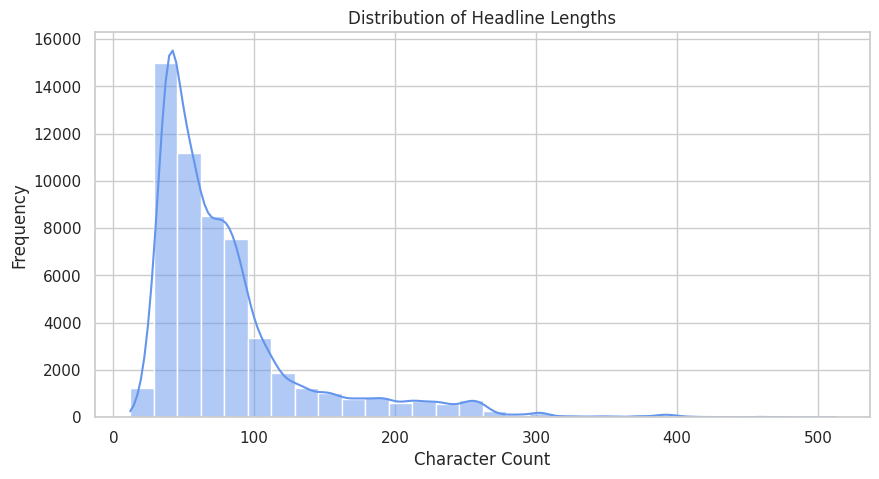

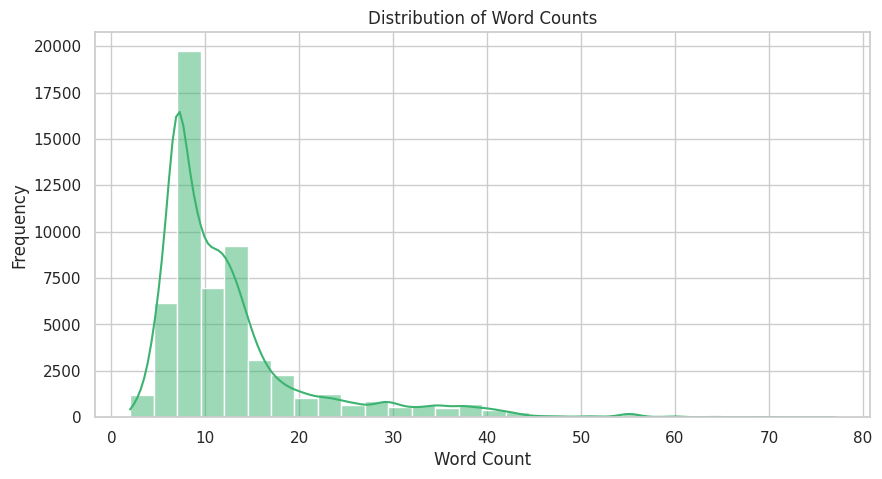

Top 10 Publishers:
 publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


/tmp/ipykernel_22916/576920124.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.head(10).values,


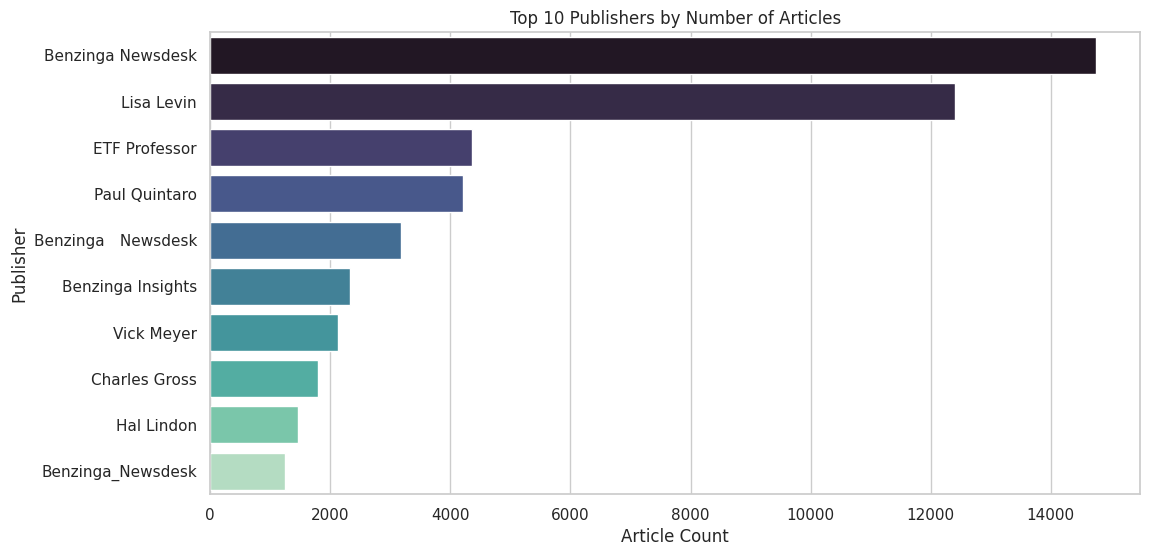

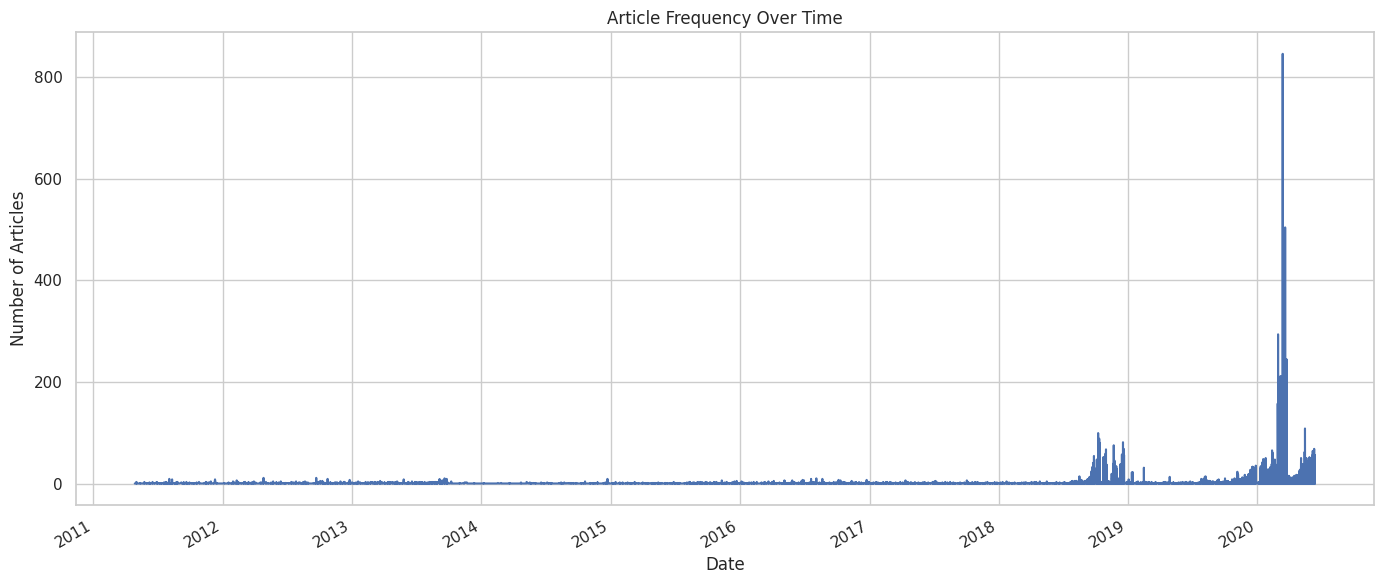

/tmp/ipykernel_22916/576920124.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=self.df, x='day_of_week',


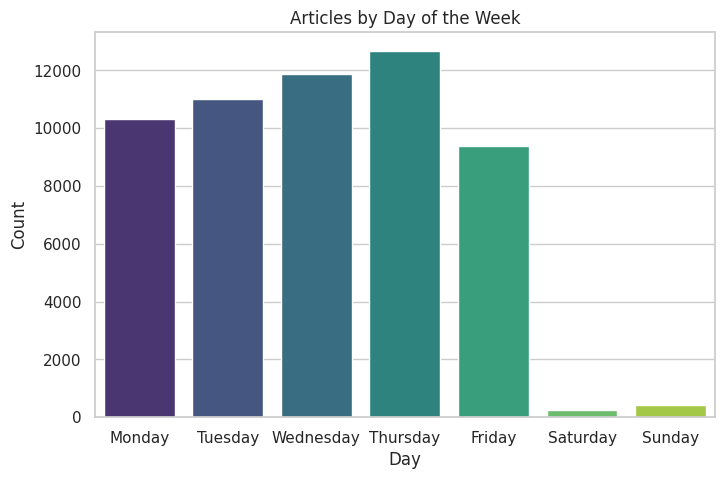

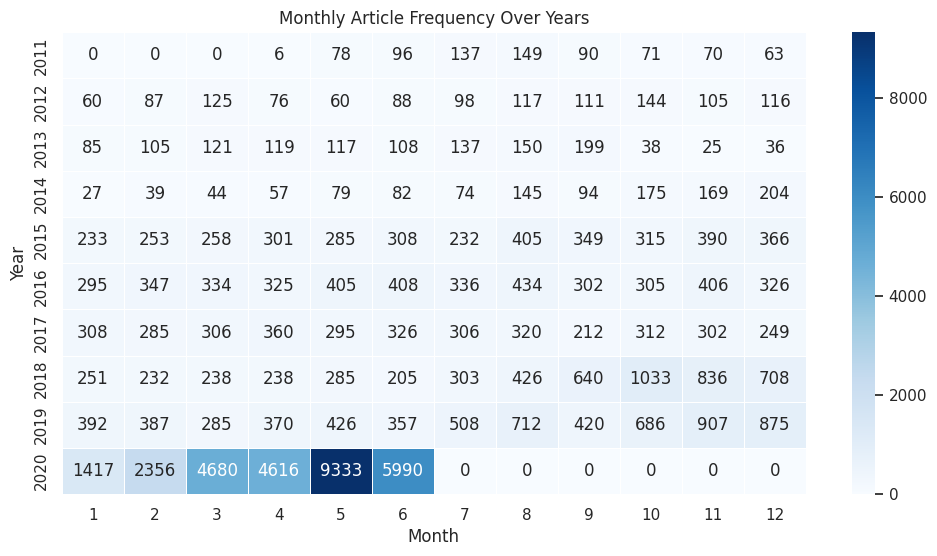

/tmp/ipykernel_22916/576920124.py:128: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_filtered['month'] = df_filtered['date'].dt.to_period('M')
/tmp/ipykernel_22916/576920124.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = df_filtered['date'].dt.to_period('M')


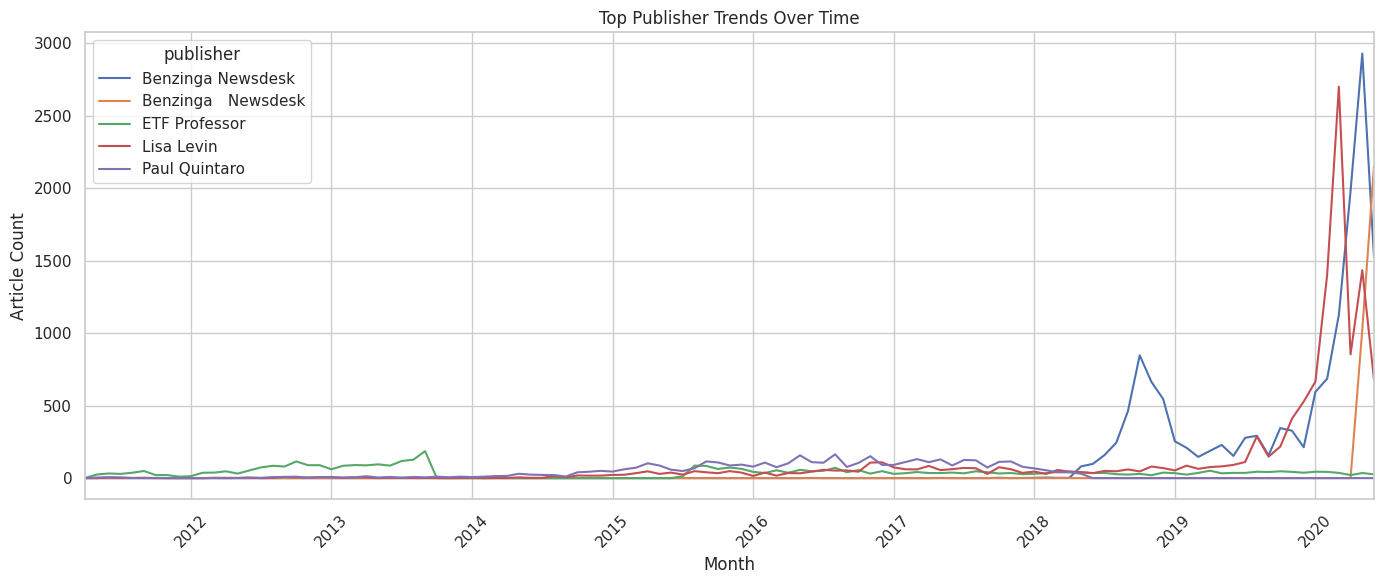

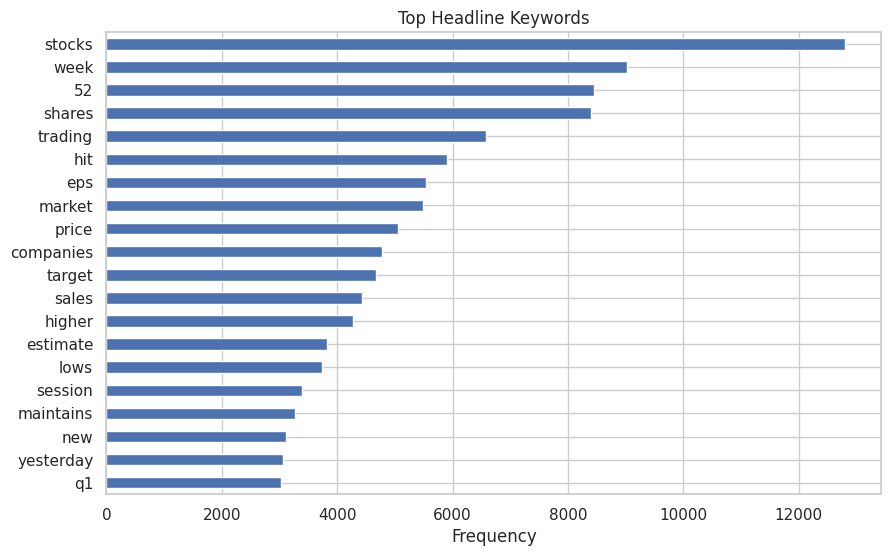

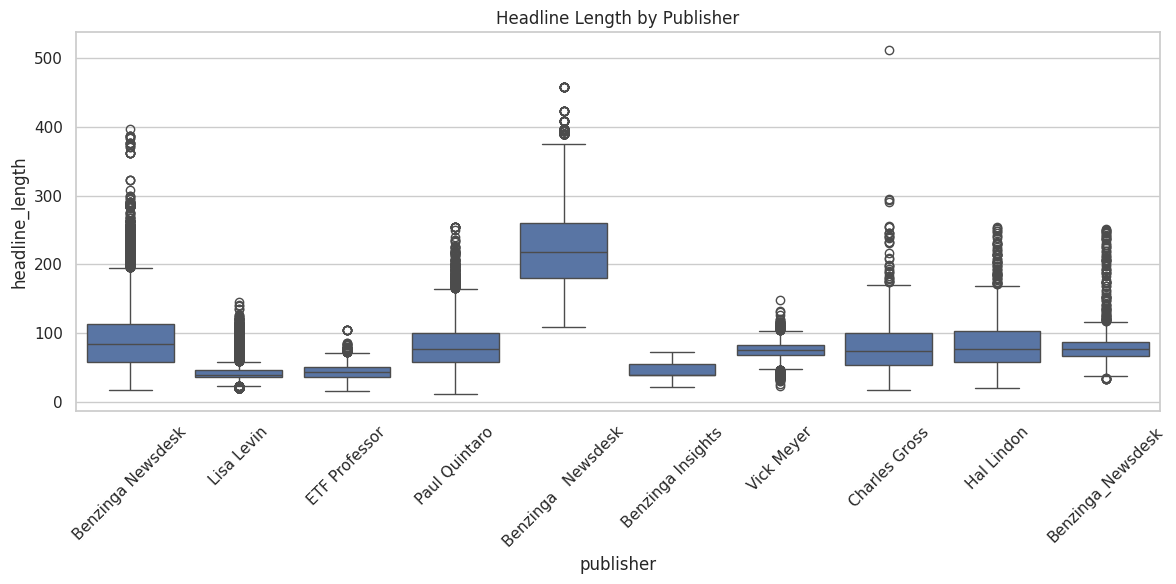

Preprocessing headlines...
Vectorizing text...
Fitting NMF model...

Topics discovered:
Topic 1: hit | week | stock | low | thursday | high | friday | wednesday | monday | tuesday
Topic 2: biggest | mover | yesterday | friday | gainer | midday | change | volume | loser | target
Topic 3: moving | session | stock | midday | premarket | wednesday | tuesday | monday | friday | thursday
Topic 4: set | new | low | yesterday | week | th | stock | october | september | nov
Topic 5: estimate | eps | sale | beat | share | trading | company | miss | yoy | higher
Analyzing article frequency over time...


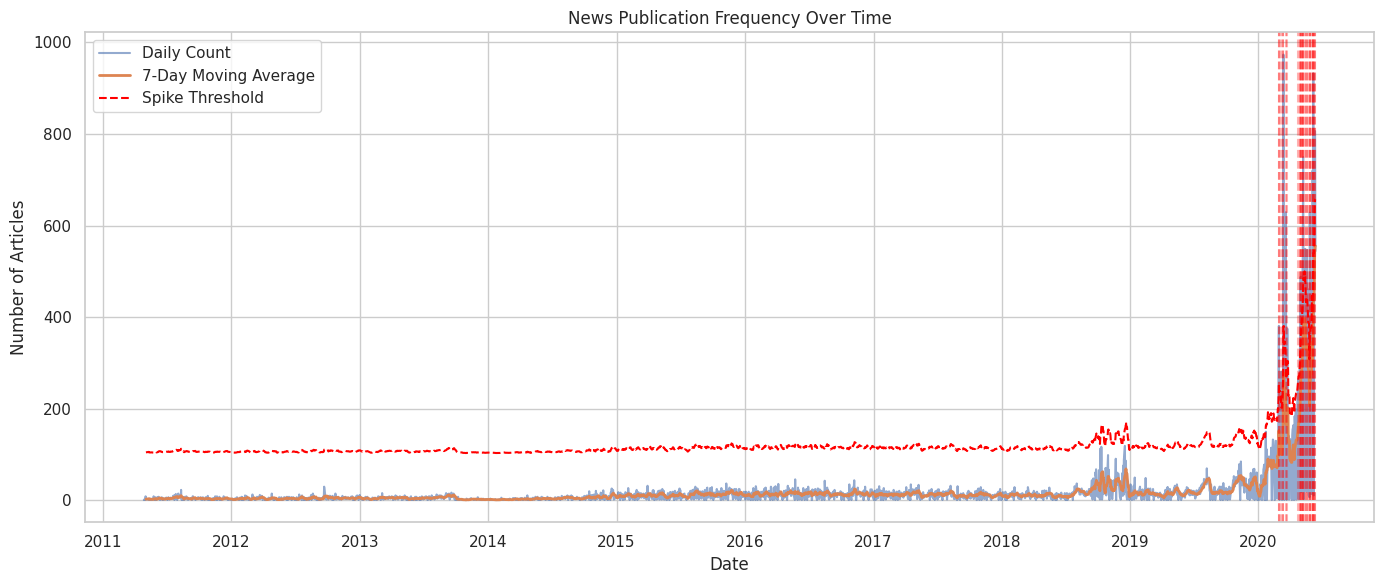

Detected 30 spike(s) in publication frequency.
Spikes occurred on:
 - 2020-02-27: 275 articles
 - 2020-02-28: 381 articles
 - 2020-03-06: 281 articles
 - 2020-03-11: 282 articles
 - 2020-03-12: 973 articles
 - 2020-03-19: 629 articles
 - 2020-03-23: 375 articles
 - 2020-04-23: 265 articles
 - 2020-04-28: 317 articles
 - 2020-04-29: 449 articles
 - 2020-04-30: 488 articles
 - 2020-05-01: 385 articles
 - 2020-05-05: 478 articles
 - 2020-05-06: 531 articles
 - 2020-05-07: 749 articles
 - 2020-05-08: 508 articles
 - 2020-05-13: 549 articles
 - 2020-05-14: 536 articles
 - 2020-05-18: 547 articles
 - 2020-05-20: 461 articles
 - 2020-05-26: 628 articles
 - 2020-05-27: 492 articles
 - 2020-05-28: 465 articles
 - 2020-06-01: 484 articles
 - 2020-06-03: 720 articles
 - 2020-06-04: 538 articles
 - 2020-06-05: 932 articles
 - 2020-06-08: 765 articles
 - 2020-06-09: 804 articles
 - 2020-06-10: 806 articles
Analyzing article publishing times (hour of day)...


/tmp/ipykernel_22916/576920124.py:268: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=self.df, palette='coolwarm')


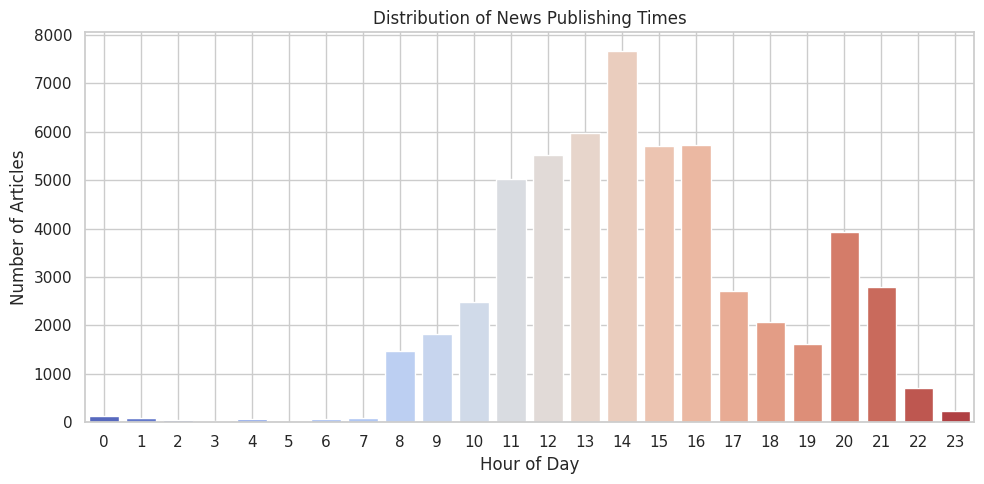

Top 10 Publishers by Article Count:
 publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


/tmp/ipykernel_22916/576920124.py:294: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=publisher_counts.head(10).index,


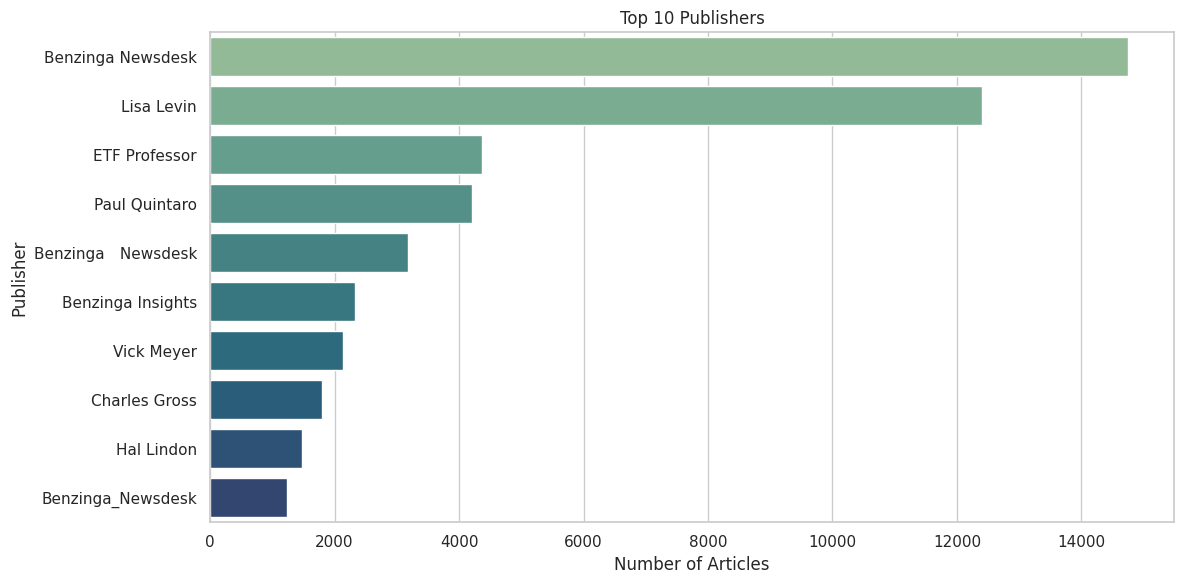


Top 10 Publisher Email Domains:
 publisher
benzinga.com    1196
gmail.com          3
Name: count, dtype: int64


/tmp/ipykernel_22916/576920124.py:312: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.head(10).values,


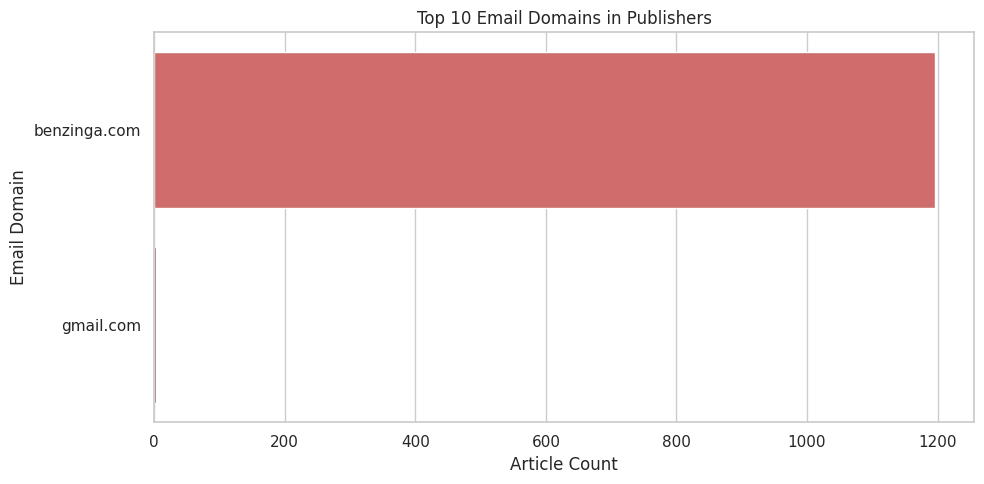


Analyzing type of news reported per top publisher (heuristic)...

Publisher: Benzinga Newsdesk
  - Finance keywords matched: 1923
  - Health keywords matched: 388
  - Tech keywords matched: 482

Publisher: Lisa Levin
  - Finance keywords matched: 1673
  - Health keywords matched: 12
  - Tech keywords matched: 53

Publisher: ETF Professor
  - Finance keywords matched: 134
  - Health keywords matched: 1
  - Tech keywords matched: 18

Publisher: Paul Quintaro
  - Finance keywords matched: 337
  - Health keywords matched: 91
  - Tech keywords matched: 72

Publisher: Benzinga Newsdesk
  - Finance keywords matched: 966
  - Health keywords matched: 677
  - Tech keywords matched: 818


In [6]:
eda = NewsHeadlineEDA(Config.DATA_PATH)

# Headline length statistics
eda.show_text_length_stats()

# Article count per publisher
eda.analyze_publishers()

# Publication trends
eda.analyze_publication_dates()
eda.show_year_month_heatmap()

# Extra insights
eda.publisher_trend_over_time()
eda.show_top_keywords()
eda.publisher_headline_length_comparison()

# Run topic modeling (choose NMF or LDA)
eda.run_topic_modeling(n_topics=5, n_top_words=10, method='nmf')

# Time Series Analysis
eda.analyze_publication_trends()
eda.analyze_publication_times()

# Publisher Analysis
eda.analyze_publishers_extended()

Processing AAPL...


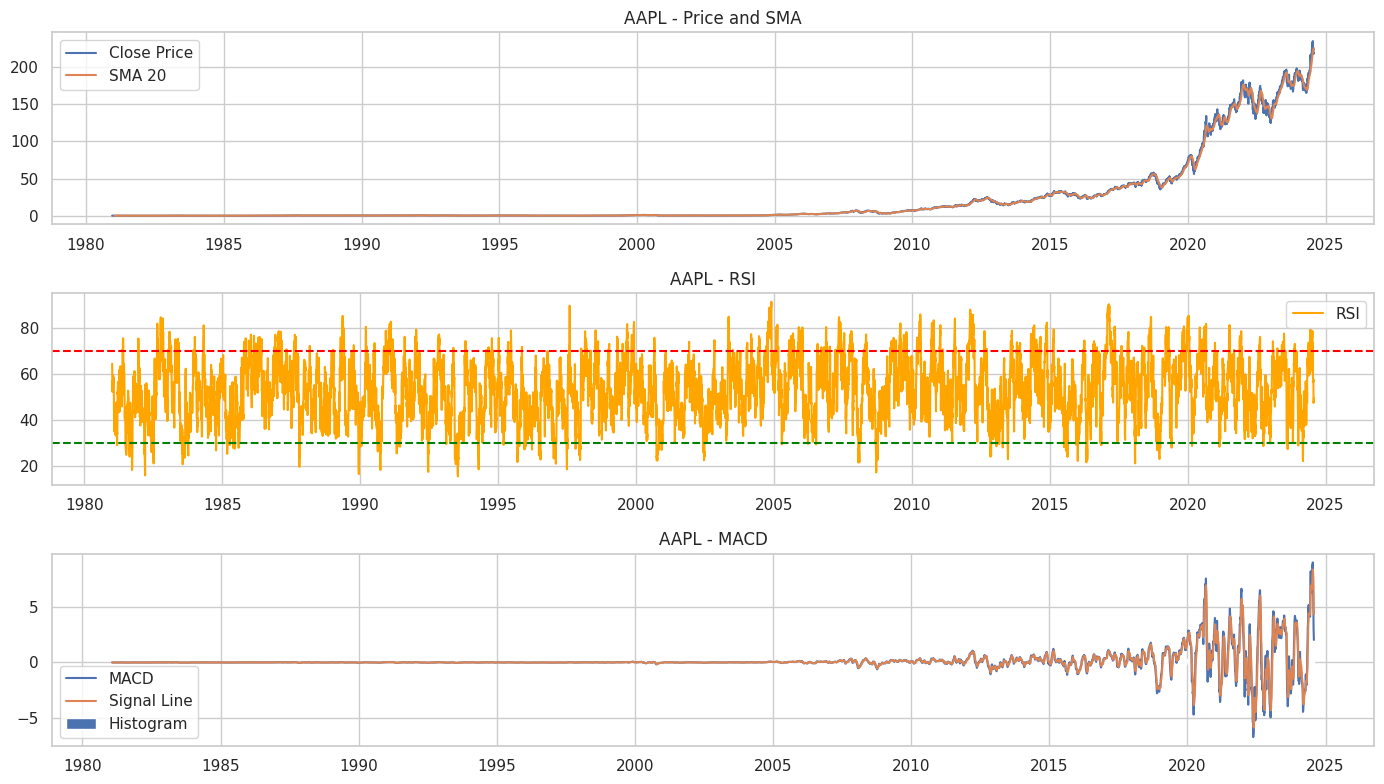

Processing AMZN...


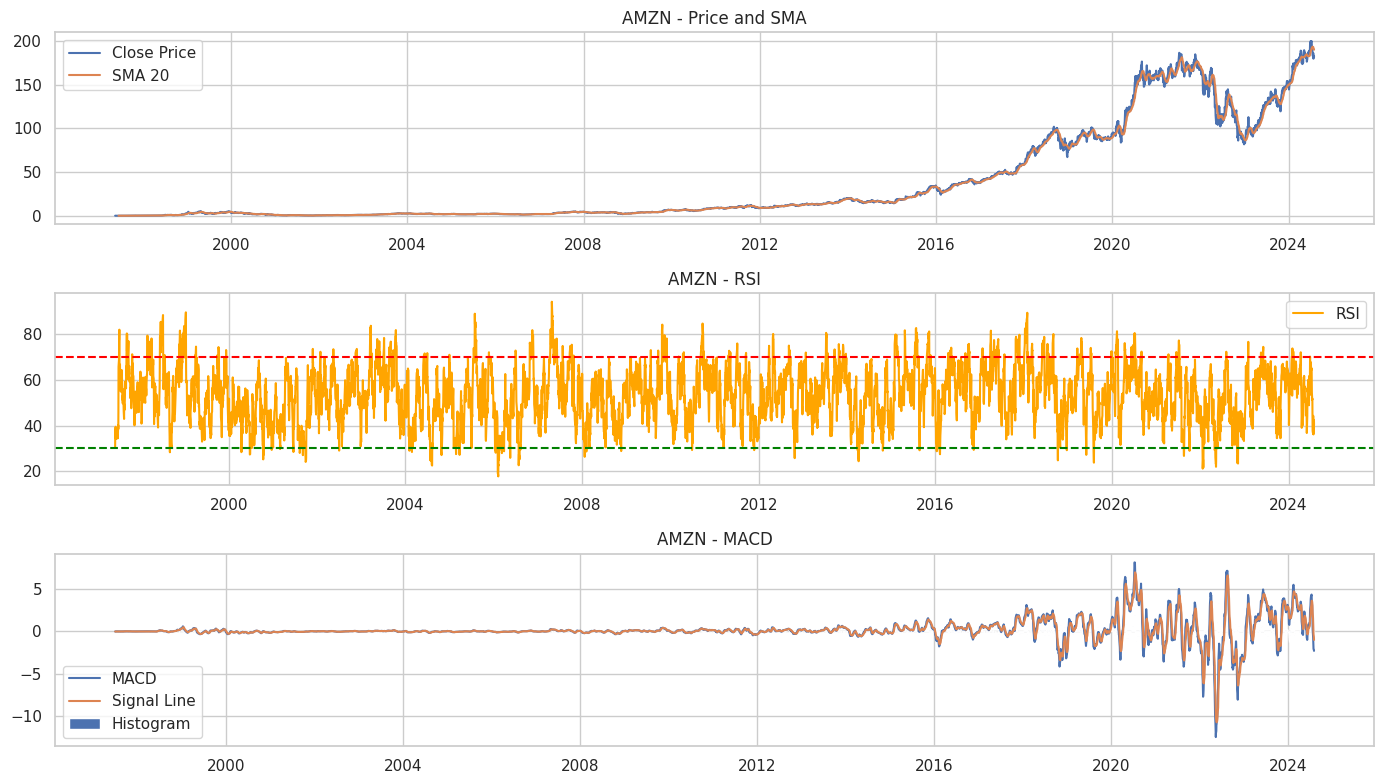

Processing GOOG...


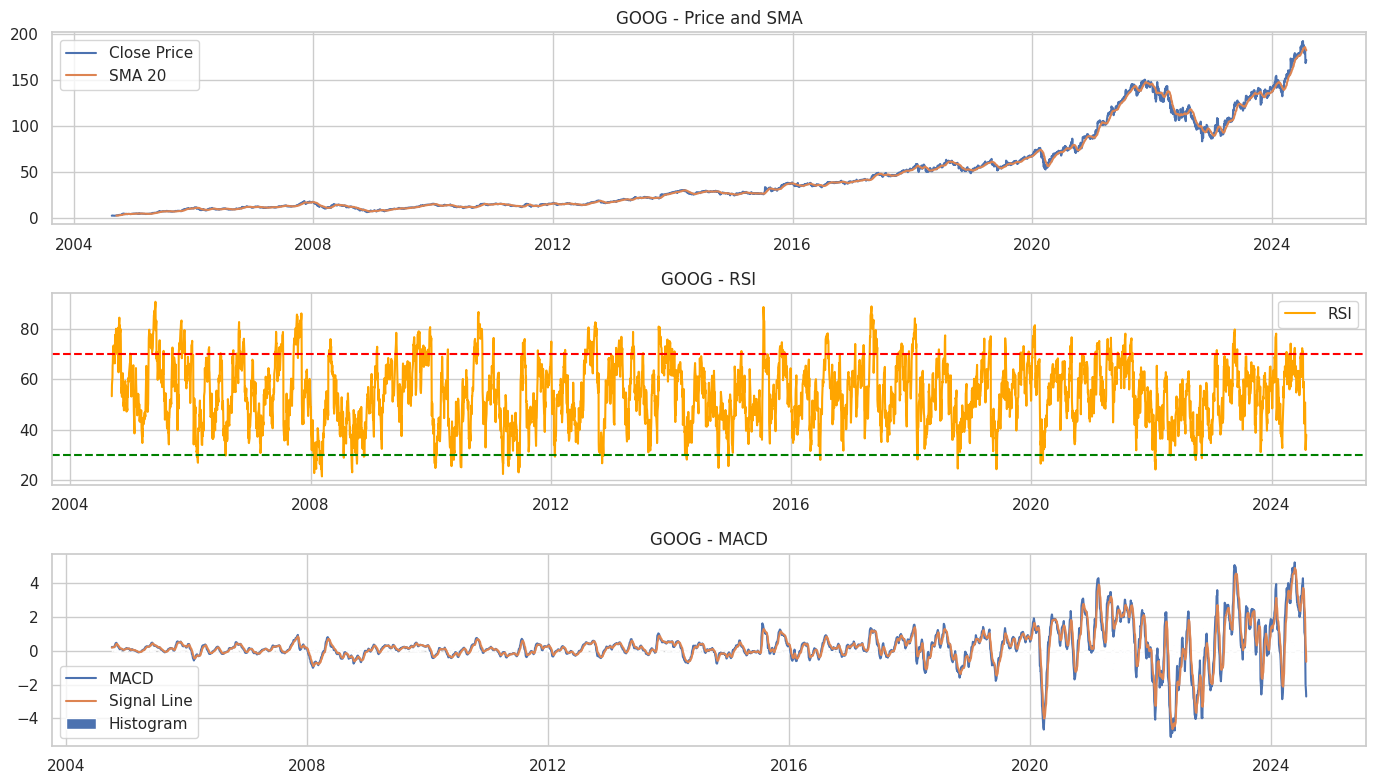

Processing META...


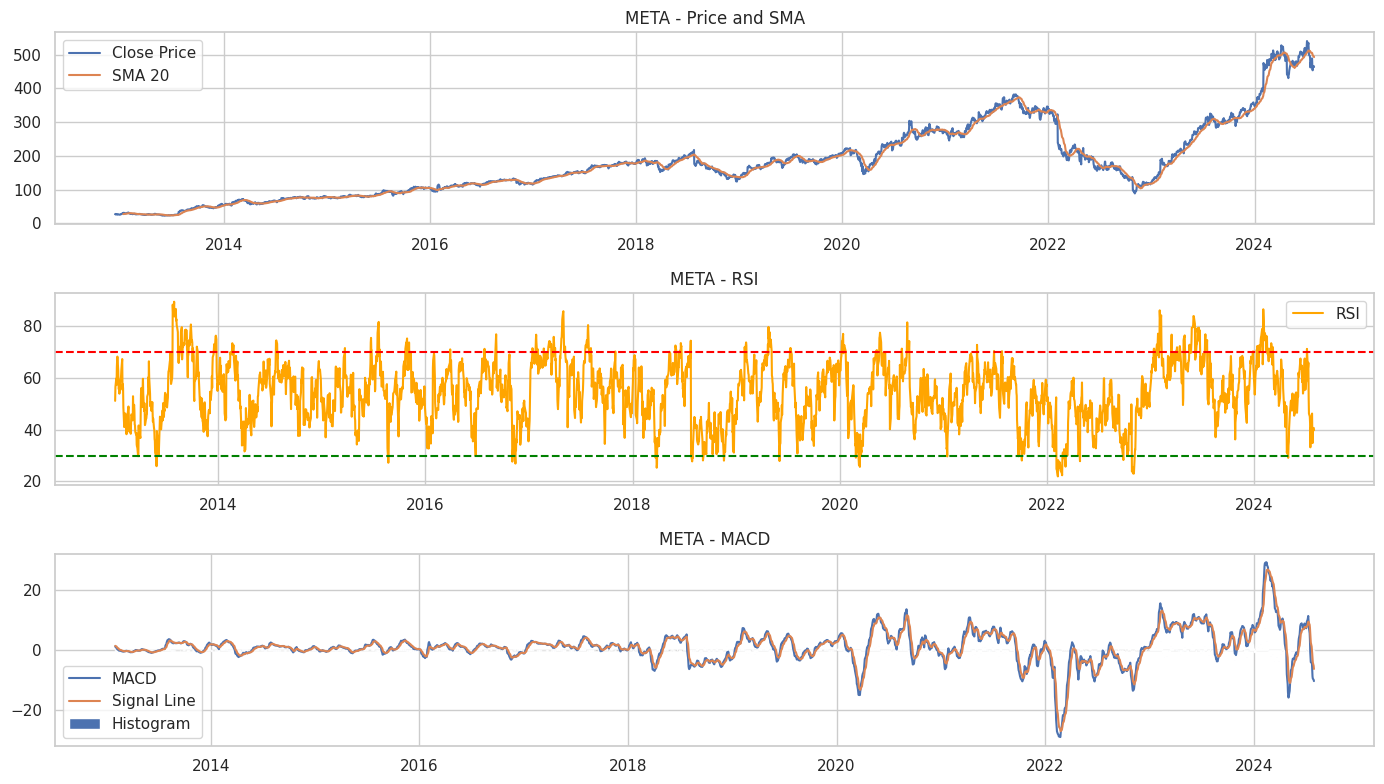

Processing MSFT...


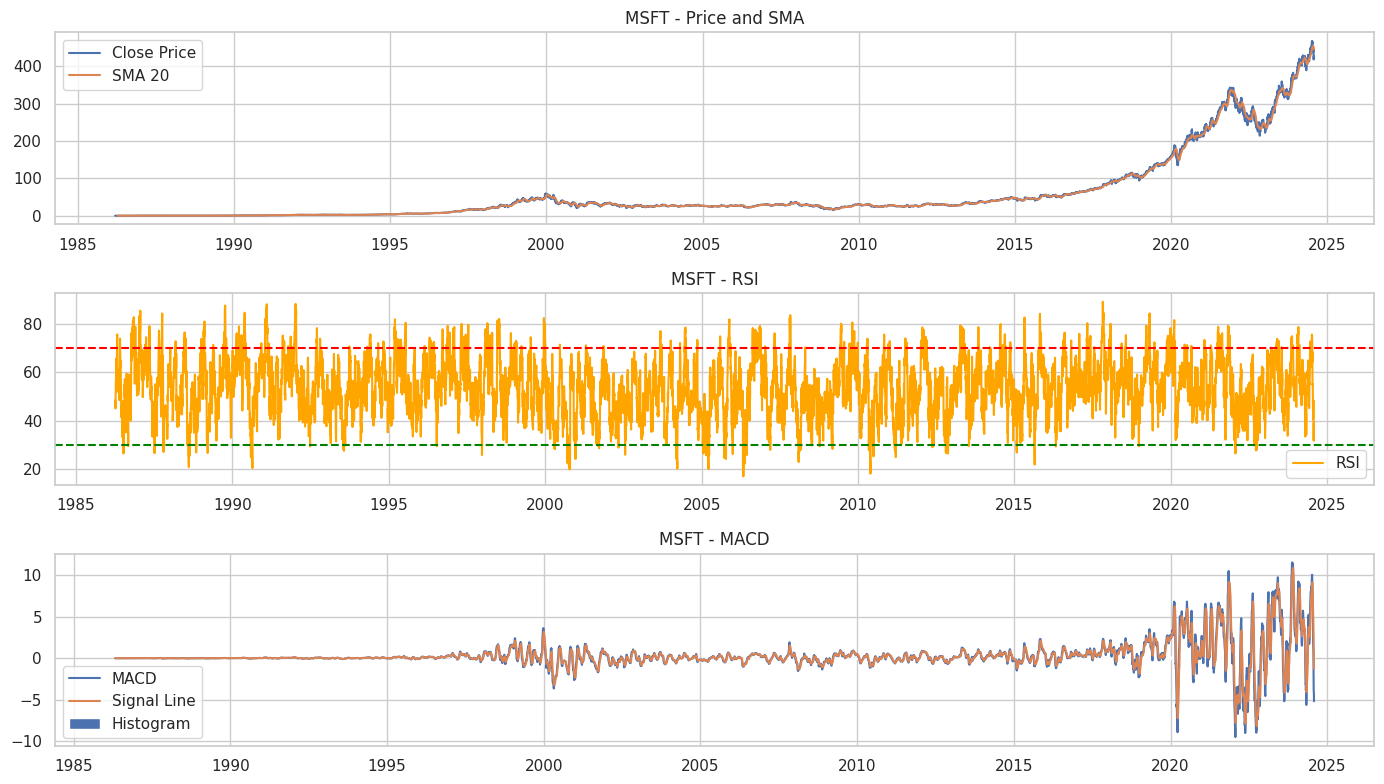

Processing NVDA...


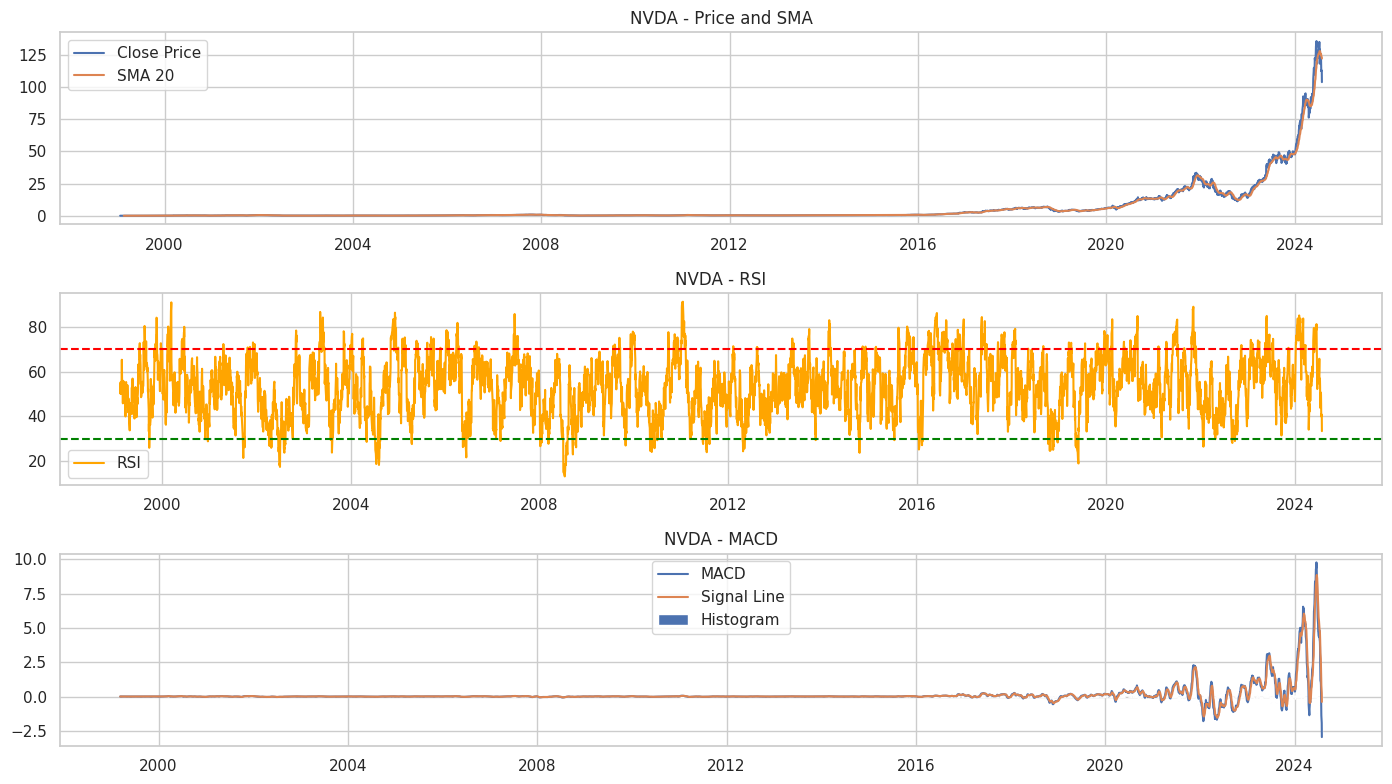

Processing TSLA...


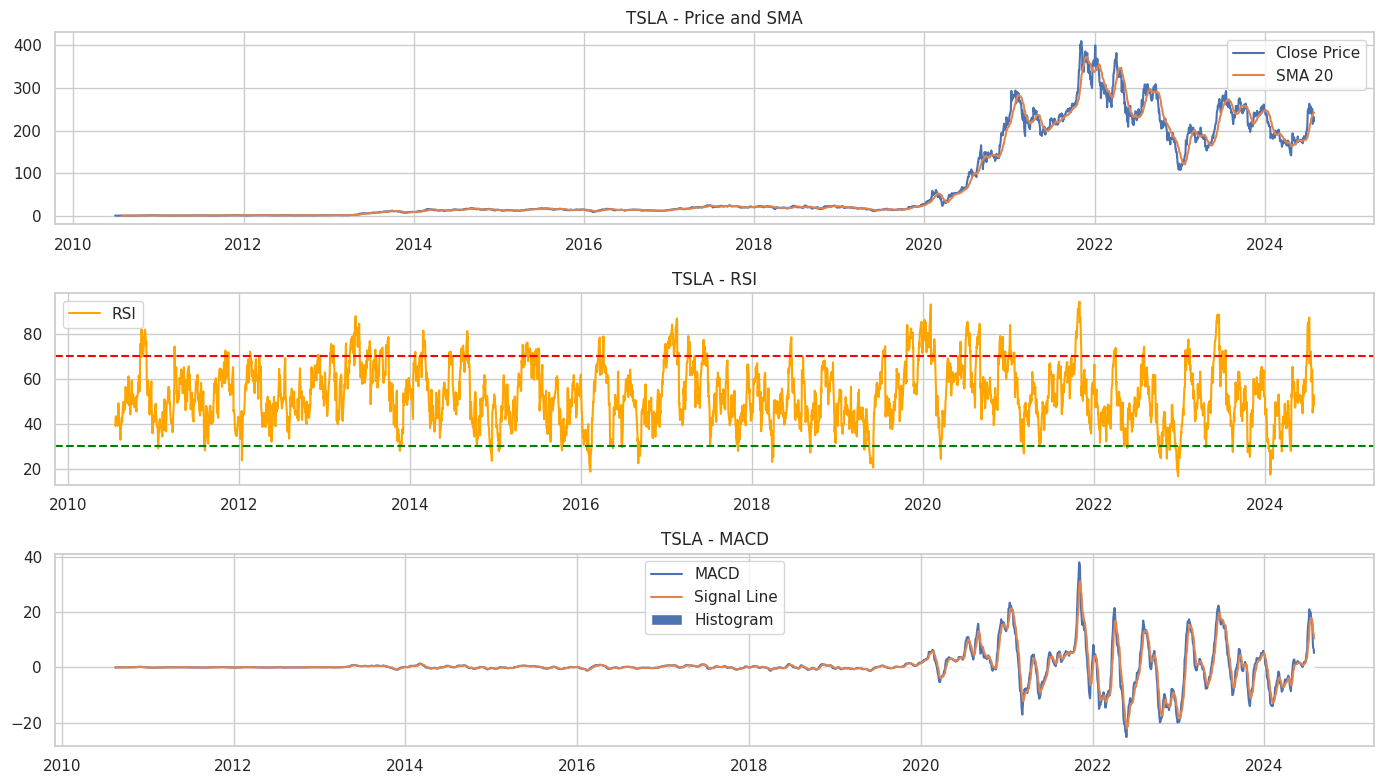

dict_keys(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'])

In [ ]:
# Task 2: Quantitative analysis using pynance and TaLib

import talib

class StockDataLoader:
    """Class to load and prepare stock data from CSV."""

    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None

    def load(self) -> pd.DataFrame:
        self.df = pd.read_csv(self.file_path)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df.set_index('Date', inplace=True)
        self.df.sort_index(inplace=True)
        return self.df[['Open', 'High', 'Low', 'Close', 'Volume']]


class TechnicalIndicators:
    """Class to calculate TA-Lib indicators."""

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def add_indicators(self) -> pd.DataFrame:
        self.df['SMA_20'] = talib.SMA(self.df['Close'], timeperiod=20)
        self.df['RSI'] = talib.RSI(self.df['Close'], timeperiod=14)
        macd, macdsignal, macdhist = talib.MACD(
            self.df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        self.df['MACD'] = macd
        self.df['MACD_Signal'] = macdsignal
        self.df['MACD_Hist'] = macdhist
        return self.df


class Visualizer:
    """Class to visualize stock prices and indicators."""
    @staticmethod
    def plot(df: pd.DataFrame, symbol: str):
        plt.figure(figsize=(14, 8))

        # Price and SMA
        plt.subplot(3, 1, 1)
        plt.plot(df.index, df['Close'], label='Close Price')
        if 'SMA_20' in df.columns:
            plt.plot(df.index, df['SMA_20'], label='SMA 20')
        plt.title(f'{symbol} - Price and SMA')
        plt.legend()

        # RSI
        plt.subplot(3, 1, 2)
        plt.plot(df.index, df['RSI'], label='RSI', color='orange')
        plt.axhline(70, color='red', linestyle='--')
        plt.axhline(30, color='green', linestyle='--')
        plt.title(f'{symbol} - RSI')
        plt.legend()

        # MACD
        plt.subplot(3, 1, 3)
        plt.plot(df.index, df['MACD'], label='MACD')
        plt.plot(df.index, df['MACD_Signal'], label='Signal Line')
        plt.bar(df.index, df['MACD_Hist'], label='Histogram')
        plt.title(f'{symbol} - MACD')
        plt.legend()

        plt.tight_layout()
        plt.show()


class StockAnalysisPipeline:
    """Main pipeline to run the analysis workflow."""

    def __init__(self, stock_files: dict):
        self.stock_files = stock_files
        self.processed_data = {}

    def run(self):
        for symbol, path in self.stock_files.items():
            print(f"Processing {symbol}...")

            # Load
            loader = StockDataLoader(path)
            df = loader.load()

            # Add indicators
            indicators = TechnicalIndicators(df)
            df_with_indicators = indicators.add_indicators()
            self.processed_data[symbol] = df_with_indicators

            # Visualize
            Visualizer.plot(df_with_indicators, symbol)

        return self.processed_data


# Define stock files mapping (symbols to their paths)
stock_files = Config.STOCK_FILES

# Run the analysis pipeline
pipeline = StockAnalysisPipeline(stock_files)
processed_data = pipeline.run()
processed_data.keys()  # Show the keys (symbols) for confirmation

In [31]:
from scipy.stats import pearsonr
import pandas as pd
from textblob import TextBlob


class NewsSentimentAnalyzer:
    def __init__(self, news_df: pd.DataFrame):
        self.news_df = news_df.copy()

    def preprocess(self):
        if not pd.api.types.is_datetime64_any_dtype(self.news_df['date']):
            self.news_df['date'] = pd.to_datetime(
                self.news_df['date'], errors='coerce')
        self.news_df['date'] = self.news_df['date'].dt.date
        
    def analyze_sentiment(self):
        def get_sentiment(text):
            return TextBlob(text).sentiment.polarity
        self.news_df['sentiment'] = self.news_df['headline'].apply(
            get_sentiment)

    def aggregate_daily_sentiment(self):
        return self.news_df.groupby('date')['sentiment'].mean().reset_index()


class StockAnalyzer:
    def __init__(self, stock_df: pd.DataFrame):
        self.stock_df = stock_df.copy()

    def preprocess(self):
        self.stock_df['date'] = pd.to_datetime(self.stock_df['Date']).dt.date
        self.stock_df.sort_values('date', inplace=True)

    def calculate_daily_returns(self):
        self.stock_df['return'] = self.stock_df['Close'].pct_change()
        return self.stock_df[['date', 'return']]
    

class CorrelationAnalyzer:
    def __init__(self, sentiment_df: pd.DataFrame, return_df: pd.DataFrame):
        self.sentiment_df = sentiment_df
        self.return_df = return_df

    def merge_data(self):
        return pd.merge(self.sentiment_df, self.return_df, on='date')

    def calculate_correlation(self, merged_df: pd.DataFrame):
        merged_df = merged_df.dropna()
        correlation, p_value = pearsonr(
            merged_df['sentiment'], merged_df['return'])
        return {
            'correlation_coefficient': correlation,
            'p_value': p_value,
            'n_samples': len(merged_df)
        }

In [32]:
# Load data
# ensure it has 'date' and 'headline'
news_df = pd.read_csv(Config.DATA_PATH)
stock_df = pd.read_csv(Config.STOCK_FILES['AAPL'])  # or TSLA

# News Sentiment Analysis
news_analyzer = NewsSentimentAnalyzer(news_df)
# Fix date parsing issue
# Ensure consistent date parsing
news_analyzer.preprocess()
news_analyzer.analyze_sentiment()
daily_sentiment = news_analyzer.aggregate_daily_sentiment()

# Stock Return Analysis
stock_analyzer = StockAnalyzer(stock_df)
stock_analyzer.preprocess()
daily_returns = stock_analyzer.calculate_daily_returns()

# Correlation Analysis
correlation_analyzer = CorrelationAnalyzer(daily_sentiment, daily_returns)
merged_data = correlation_analyzer.merge_data()
result = correlation_analyzer.calculate_correlation(merged_data)

# Output result
print("Correlation Analysis Result:")
print(result)

Correlation Analysis Result:
{'correlation_coefficient': np.float64(-0.0020328064776582583), 'p_value': np.float64(0.9236356846935341), 'n_samples': 2226}
